Importing libraries and models needed

In [ ]:
# System Libraries
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# Data Handling Tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
print('Modules loaded')


Modules loaded


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving brain_tumor_dataset.zip to brain_tumor_dataset (1).zip


Setting up the dataset, prepareing the file paths and labels, and splits the data into training and testing sets,

In [ ]:
# Unzip the dataset
import zipfile
with zipfile.ZipFile('brain_tumor_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')
data_dir = '/content/brain_tumor_dataset'
if os.path.exists(data_dir):
    print(f"Directory {data_dir} exists.")
else:
    print(f"Directory {data_dir} does not exist.")
filepaths = []
labels = []
folds = os.listdir(data_dir)

# Iterate over each class folder
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
# Convert file paths and labels into a DataFrame
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
df.head()

# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=df['labels'])


Directory /content/brain_tumor_dataset exists.


 Loading and preprocessing images in batches during model training and evaluation

In [ ]:
# Define image size and batch size
img_size = (224, 224)
batch_size = 8

# Initialize ImageDataGenerators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Create data generators
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


Visualizing sample images

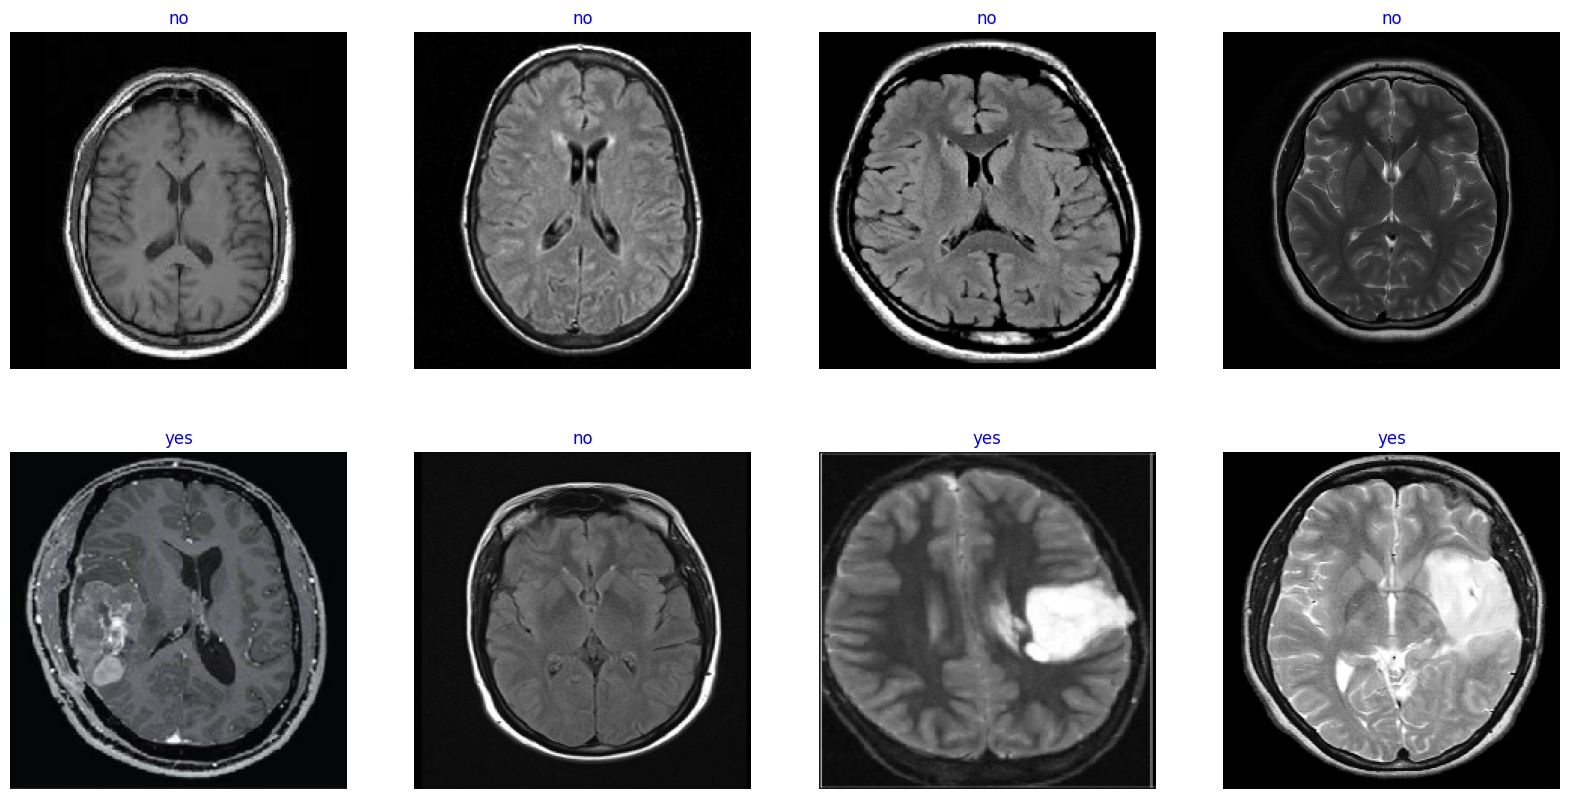

In [ ]:
images, labels = next(train_gen)
plt.figure(figsize=(20, 10))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = list(train_gen.class_indices.keys())[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()


Constructing a CNN model using the EfficientNetB3 architecture for image classification, including batch normalization, dense layers with regularization, dropout, and softmax activation, compiled with Adamax optimizer and categorical cross-entropy loss.

In [ ]:
img_shape = (img_size[0], img_size[1], 3)
base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(len(train_gen.class_indices), activation='softmax')
])
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization_3 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 256)               393472    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11183665 (42.66 MB)
Trainable params: 11

Training the model

In [13]:

epochs = 30
history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=test_gen, validation_steps=None, shuffle=False)


Epoch 1/30
26/26 [==============================] - 129s 5s/step - loss: 2.6132 - accuracy: 0.9802 - val_loss: 2.7649 - val_accuracy: 0.9020
Epoch 2/30
26/26 [==============================] - 101s 4s/step - loss: 2.5289 - accuracy: 0.9851 - val_loss: 2.6745 - val_accuracy: 0.9020
Epoch 3/30
26/26 [==============================] - 100s 4s/step - loss: 2.4602 - accuracy: 0.9901 - val_loss: 2.6396 - val_accuracy: 0.9020
Epoch 4/30
26/26 [==============================] - 98s 4s/step - loss: 2.3793 - accuracy: 0.9950 - val_loss: 2.5692 - val_accuracy: 0.9020
Epoch 5/30
26/26 [==============================] - 99s 4s/step - loss: 2.3484 - accuracy: 0.9851 - val_loss: 2.4914 - val_accuracy: 0.9020
Epoch 6/30
26/26 [==============================] - 97s 4s/step - loss: 2.2702 - accuracy: 0.9901 - val_loss: 2.4352 - val_accuracy: 0.9020
Epoch 7/30
26/26 [==============================] - 104s 4s/step - loss: 2.2000 - accuracy: 0.9950 - val_loss: 2.3648 - val_accuracy: 0.9020
Epoch 8/30
26/26

Plotting the training and validation accuracy and loss values over epochs then it evaluates the trained model on both the training and testing datasets, displaying the loss and accuracy scores

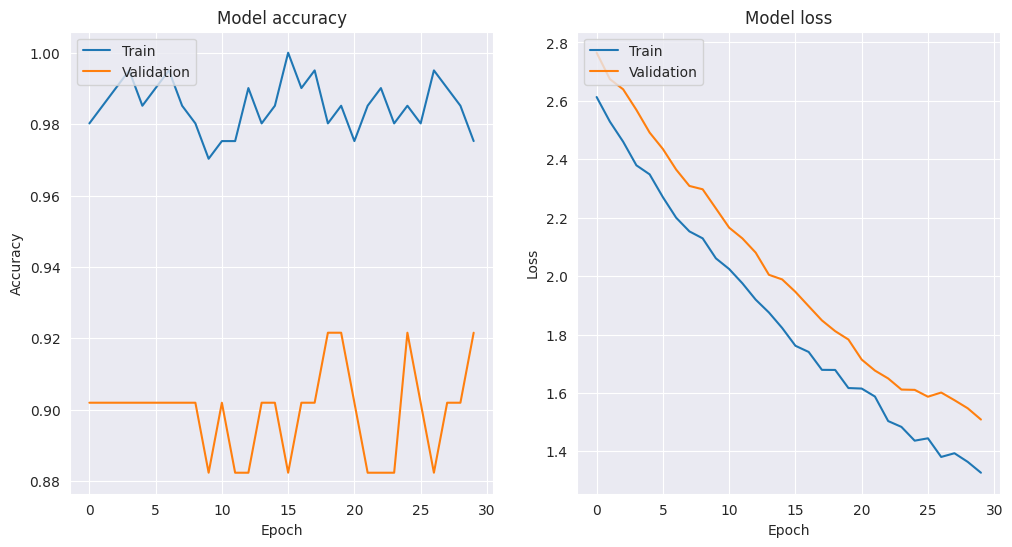

7/7 [==============================] - 6s 849ms/step - loss: 1.5089 - accuracy: 0.9216
Train Loss:  1.2885551452636719
Train Accuracy:  0.9950494766235352
--------------------
Test Loss:  1.5089212656021118
Test Accuracy:  0.9215686321258545


In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model
train_score = model.evaluate(train_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


Preprocesseing the images by resizing them &
Extracting features from the pre-trained model for each image

In [17]:
def preprocess_and_extract_features(file_paths, model):
    features = []
    for file_path in file_paths:
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=img_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
        features.append(model.predict(np.expand_dims(img_array, axis=0))[0])
    return np.array(features)

# Split data into train and test sets
X_train_paths, X_test_paths, y_train, y_test = train_test_split(df['filepaths'].values,
                                                                df['labels'].values, test_size=0.2, random_state=42)
# Preprocess and extract features for training and test sets
X_train = preprocess_and_extract_features(X_train_paths, model)
X_test = preprocess_and_extract_features(X_test_paths, model)
# Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
one_hot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = one_hot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
y_test_onehot = one_hot_encoder.transform(y_test_encoded.reshape(-1, 1))


1/1 [==============================] - 0s 202ms/step


Training a RBF classifier using Support Vector Classification &  predicting on the test data to evaluate performance

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
rbf_classifier = SVC(kernel='rbf', probability=True)
rbf_classifier.fit(X_train, y_train_encoded)
y_pred_rbf = rbf_classifier.predict(X_test)
print("RBF Classifier Accuracy: ", accuracy_score(y_test_encoded, y_pred_rbf))
print("RBF Classifier Report:\n", classification_report(y_test_encoded, y_pred_rbf))


RBF Classifier Accuracy:  0.9803921568627451
RBF Classifier Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.97      1.00      0.98        31

    accuracy                           0.98        51
   macro avg       0.98      0.97      0.98        51
weighted avg       0.98      0.98      0.98        51



Training Decsion tree & predicting on test data to evaulate performance

In [20]:
from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train_encoded)
y_pred_dt = dt_classifier.predict(X_test)
print("Decision Tree Classifier Accuracy: ", accuracy_score(y_test_encoded, y_pred_dt))
print("Decision Tree Classifier Report:\n", classification_report(y_test_encoded, y_pred_dt))


Decision Tree Classifier Accuracy:  0.9803921568627451
Decision Tree Classifier Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.97      1.00      0.98        31

    accuracy                           0.98        51
   macro avg       0.98      0.97      0.98        51
weighted avg       0.98      0.98      0.98        51



Saving the trained neural network model, that will contain the architecture, weights, and configuration of the model.

In [ ]:
model.save('Model.h5')


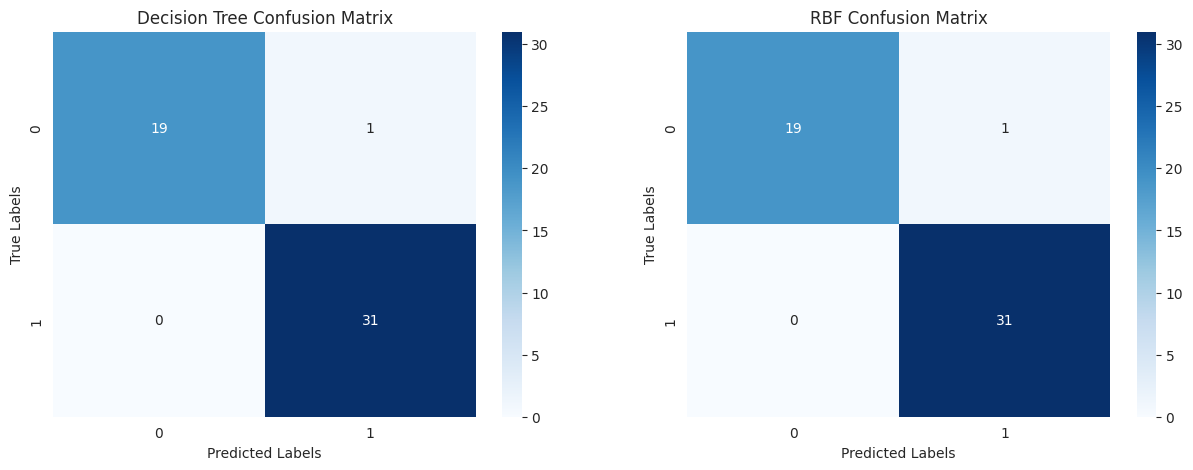

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

dt_confusion_matrix = confusion_matrix(y_test_encoded, y_pred_dt)
rf_confusion_matrix = confusion_matrix(y_test_encoded, y_pred_rbf)

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(dt_confusion_matrix, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('Decision Tree Confusion Matrix')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

sns.heatmap(rf_confusion_matrix, annot=True, fmt='d', ax=ax[1], cmap='Blues')
ax[1].set_title('RBF Confusion Matrix')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.show()